# MLP - Multilayer Perceptron

Importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from ipynb.fs.defs.Additional_metrics import *

Defining functions that will perform .fit() and .predict() while calculating execution time 

In [2]:
def mlp_fit_with_time(mlp, X_trainCV, y_trainCV, time_fit_tmp):
    start = time.time()     
    mlp.fit(X_trainCV, y_trainCV)
    time_fit_tmp.append(time.time()-start)

In [3]:
def mlp_predict_with_time(mlp, X_testCV, time_pred_tmp):
    start = time.time()
    y_pred = mlp.predict(X_testCV)
    time_pred_tmp.append(time.time()-start)
    return y_pred

Getting touple values for number of neurons in layers, where every layer has same or same neurons than the previous layer

In [4]:
import itertools 

x = [128, 96, 64, 32] 
hd_list = list(itertools.combinations(x,3)) + list(itertools.combinations(x,2)) + [(128,128,128), (96,96,96), (64,64,64), (32,32,32), (128,128), (96,96), (64,64)]
print(hd_list)

[(128, 96, 64), (128, 96, 32), (128, 64, 32), (96, 64, 32), (128, 96), (128, 64), (128, 32), (96, 64), (96, 32), (64, 32), (128, 128, 128), (96, 96, 96), (64, 64, 64), (32, 32, 32), (128, 128), (96, 96), (64, 64)]


## Trained on 30% samples of the original training dataset

In [5]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [6]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_train_std, y_train, test_size=0.7, stratify=y_train, random_state=42)

In [7]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
acc = []
i, best_acc, best_bs  = 0, 0, 0
best_a, best_s = '', ''
best_hd = ()

for hd in hd_list:
    for a in ["logistic", "tanh", "relu"]:
        # "lbfgs" isn't good for big datasets
        for s in ["sgd", "adam"]:
            for bs in [50]:

                acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
                
                indexes = kf.split(X_train_30, y_train_30)

                for train_index, test_index in indexes:

                    X_trainCV1 = X_train_30.iloc[train_index,:]
                    y_trainCV1 = y_train_30.iloc[train_index]
                    X_testCV1 = X_train_30.iloc[test_index,:]
                    y_testCV1 = y_train_30.iloc[test_index]

                    classifier1 = MLPClassifier(hidden_layer_sizes = hd, activation = a,
                                        solver = s, batch_size = bs, learning_rate = "constant", 
                                        learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                                        random_state = 42, early_stopping = True, n_iter_no_change = 10,
                                        validation_fraction = 0.1, verbose = False)
                    
                    mlp_fit_with_time(classifier1, X_trainCV1.values, y_trainCV1.values, time_fit_tmp)
                    y_pred1 = mlp_predict_with_time(classifier1, X_testCV1.values, time_pred_tmp)

                    c1 = confusion_matrix(y_testCV1, y_pred1)
                    acc_tmp.append(np.trace(c1)/sum(sum(c1)))

                print(f"{i+1}. Hd = {hd}, bs = {bs}, s = {s}, a = {a}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
                acc.append(np.mean(acc_tmp))
                i += 1

                if np.mean(acc_tmp) > best_acc:
                    best_acc = np.mean(acc_tmp)
                    best_hd, best_a, best_s, best_bs = hd, a, s, bs
            
    print('')
      
print('-------------------')
print('Best accuracy is in iteration number: ', np.argmax(acc) + 1)

1. Hd = (128, 96, 64), bs = 50, s = sgd, a = logistic, Average accuracy: 0.746944 | Average fit time: 70.996191s | Average predict time: 0.023421s
2. Hd = (128, 96, 64), bs = 50, s = adam, a = logistic, Average accuracy: 0.858167 | Average fit time: 11.383962s | Average predict time: 0.023622s
3. Hd = (128, 96, 64), bs = 50, s = sgd, a = tanh, Average accuracy: 0.856556 | Average fit time: 16.879564s | Average predict time: 0.032229s
4. Hd = (128, 96, 64), bs = 50, s = adam, a = tanh, Average accuracy: 0.859278 | Average fit time: 11.728075s | Average predict time: 0.034031s
5. Hd = (128, 96, 64), bs = 50, s = sgd, a = relu, Average accuracy: 0.860278 | Average fit time: 14.283200s | Average predict time: 0.020419s
6. Hd = (128, 96, 64), bs = 50, s = adam, a = relu, Average accuracy: 0.861778 | Average fit time: 10.979794s | Average predict time: 0.020419s

7. Hd = (128, 96, 32), bs = 50, s = sgd, a = logistic, Average accuracy: 0.440944 | Average fit time: 18.443788s | Average predict

#### Training on 30% training samples, test on test dataset

In [8]:
classifier1 = MLPClassifier(hidden_layer_sizes = best_hd, activation = best_a,
                    solver = best_s, batch_size = best_bs, learning_rate = "constant", 
                    learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                    random_state = 42, early_stopping = True, n_iter_no_change = 10,
                    validation_fraction = 0.1, verbose = False)

start1 = time.time()
classifier1.fit(X_train_30.values, y_train_30.values)
fit_time = time.time() - start1

start2 = time.time()
y_pred2 = classifier1.predict(X_test_std.values)
pred_time = time.time() - start2

c2 = confusion_matrix(y_test, y_pred2, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c2)/sum(sum(c2)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('MLP parameters: hd = ', best_hd, ', bs = ', best_bs, ', s = ', best_s, ', a = ', best_a, sep='')

Accuracy: 0.868900 | Average fit time: 8.298553s | Average predict time: 0.059054s
-------------------
MLP parameters: hd = (128, 128), bs = 50, s = adam, a = relu


.

## Trained on 100% samples of the original training dataset

In [9]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc, acc_tmp, time_fit_tmp, time_pred_tmp = [], [], [], []

indexes = kf.split(X_train, y_train)
        
for train_index, test_index in indexes:
    
    X_trainCV2 = X_train_std.iloc[train_index,:]
    y_trainCV2 = y_train.iloc[train_index]
    X_testCV2 = X_train_std.iloc[test_index,:]
    y_testCV2 = y_train.iloc[test_index]
                   
    classifier2 = MLPClassifier(hidden_layer_sizes = best_hd, activation = best_a,
                        solver = best_s, batch_size = best_bs, learning_rate = "constant", 
                        learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                        random_state = 42, early_stopping = True, n_iter_no_change = 10,
                        validation_fraction = 0.1, verbose = False)
    
    mlp_fit_with_time(classifier2, X_trainCV2.values, y_trainCV2.values, time_fit_tmp)
    y_pred3 = mlp_predict_with_time(classifier2, X_testCV2.values, time_pred_tmp)

    c3 = confusion_matrix(y_testCV2, y_pred3)
    acc_tmp.append(np.trace(c3)/sum(sum(c3)))

    print(f"        Accuracy: {np.trace(c3)/sum(sum(c3)):.6f} | Fit time: {time_fit_tmp[-1]:.6f}s | Predict time: {time_pred_tmp[-1]:.6f}s")

print("")    
print('-------------------')
print(f"Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")

        Accuracy: 0.889417 | Fit time: 31.740891s | Predict time: 0.069062s
        Accuracy: 0.880333 | Fit time: 46.302145s | Predict time: 0.066060s
        Accuracy: 0.894583 | Fit time: 37.521152s | Predict time: 0.066060s
        Accuracy: 0.886417 | Fit time: 35.970741s | Predict time: 0.071065s
        Accuracy: 0.882500 | Fit time: 25.610311s | Predict time: 0.075069s

-------------------
Average accuracy: 0.886650 | Average fit time: 35.429048s | Average predict time: 0.069463s


##### Training on 100% training samples, test on test dataset

In [11]:
classifier2 = MLPClassifier(hidden_layer_sizes = best_hd, activation = best_a,
                    solver = best_s, batch_size = best_bs, learning_rate = "constant", 
                    learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                    random_state = 42, early_stopping = True, n_iter_no_change = 10,
                    validation_fraction = 0.1, verbose = False)

start1 = time.time()
classifier2.fit(X_train_std.values, y_train.values)
fit_time = time.time() - start1

start2 = time.time()
y_pred4 = classifier2.predict(X_test_std.values)
pred_time = time.time() - start2

c4 = confusion_matrix(y_test, y_pred4, labels=[0,1,2,3,4,5,6,7,8,9])  

print(f"Accuracy: {np.trace(c4)/sum(sum(c4)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('MLP parameters: hd = ', best_hd, ', bs = ', best_bs, ', s = ', best_s, ', a = ', best_a, sep='')

Accuracy: 0.893700 | Average fit time: 48.675303s | Average predict time: 0.055051s
-------------------
MLP parameters: hd = (128, 128), bs = 50, s = adam, a = relu


.

## Trained on 100% samples with PCA reduction

In [12]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [13]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = []
i, best_acc, best_pca = 0, 0, 0
best_a, best_s = '', ''
best_hd = ()
best_bs = 50

for hd in hd_list:
    for a in ["logistic", "tanh", "relu"]:
        for s in ["sgd", "adam"]:
            for pc in [0.9]:

                acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
                
                indexes = kf.split(X_train, y_train)

                for train_index, test_index in indexes:

                    X_trainCV3 = X_train_std.iloc[train_index,:]
                    y_trainCV3 = y_train.iloc[train_index]
                    X_testCV3 = X_train_std.iloc[test_index,:]
                    y_testCV3 = y_train.iloc[test_index]

                    pca = PCA(n_components=pc)
                    pca.fit(X_trainCV3)
                    X_train_r = pca.transform(X_trainCV3)
                    X_test_r = pca.transform(X_testCV3)
   
                    classifier3 = MLPClassifier(hidden_layer_sizes = hd, activation = a,
                                        solver = s, batch_size = best_bs, learning_rate = "constant", 
                                        learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                                        random_state = 42, early_stopping = True, n_iter_no_change = 10,
                                        validation_fraction = 0.1, verbose = False)
                    
                    mlp_fit_with_time(classifier3, X_train_r, y_trainCV3, time_fit_tmp)
                    y_pred5 = mlp_predict_with_time(classifier3, X_test_r, time_pred_tmp)

                    c5 = confusion_matrix(y_testCV3, y_pred5, labels=[0,1,2,3,4,5,6,7,8,9])
                    acc_tmp.append(np.trace(c5)/sum(sum(c5)))

                print(f"{i+1}. pca = {pc:.2f}, hd = {hd}, s = {s}, a = {a}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
                acc.append(np.mean(acc_tmp))
                i += 1

                if np.mean(acc_tmp) > best_acc:
                    best_acc = np.mean(acc_tmp)
                    best_hd, best_a, best_s, best_pca = hd, a, s, pc
            
    print('')
      
print('-------------------')
print('Best accuracy is in iteration number: ', np.argmax(acc) + 1)

1. pca = 0.90, hd = (128, 96, 64), s = sgd, a = logistic, Average accuracy: 0.880333 | Average fit time: 126.953365s | Average predict time: 0.054049s
2. pca = 0.90, hd = (128, 96, 64), s = adam, a = logistic, Average accuracy: 0.884133 | Average fit time: 22.224031s | Average predict time: 0.051046s
3. pca = 0.90, hd = (128, 96, 64), s = sgd, a = tanh, Average accuracy: 0.881417 | Average fit time: 46.599624s | Average predict time: 0.076870s
4. pca = 0.90, hd = (128, 96, 64), s = adam, a = tanh, Average accuracy: 0.882200 | Average fit time: 19.026719s | Average predict time: 0.084076s
5. pca = 0.90, hd = (128, 96, 64), s = sgd, a = relu, Average accuracy: 0.885150 | Average fit time: 34.953017s | Average predict time: 0.040637s
6. pca = 0.90, hd = (128, 96, 64), s = adam, a = relu, Average accuracy: 0.886650 | Average fit time: 17.792797s | Average predict time: 0.040435s

7. pca = 0.90, hd = (128, 96, 32), s = sgd, a = logistic, Average accuracy: 0.883017 | Average fit time: 123.40

##### Training on 100% training samples with PCA reduction, test on test dataset

In [14]:
pca = PCA(n_components=best_pca)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)

classifier3 = MLPClassifier(hidden_layer_sizes = best_hd, activation = best_a,
                    solver = best_s, batch_size = best_bs, learning_rate = "constant", 
                    learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                    random_state = 42, early_stopping = True, n_iter_no_change = 10,
                    validation_fraction = 0.1, verbose = False)

start1 = time.time()
classifier3.fit(X_train_r, y_train) 
fit_time = time.time() - start1

start2 = time.time()
y_pred6 = classifier3.predict(X_test_r)
pred_time = time.time() - start2

c6 = confusion_matrix(y_test, y_pred6, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c6)/sum(sum(c6)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('MLP parameters: hd = ', best_hd, ', bs = ', best_bs, ', s = ', best_s, ', a = ', best_a, ', pca = ', best_pca, sep='')

Accuracy: 0.892100 | Average fit time: 65.318456s | Average predict time: 0.031029s
-------------------
MLP parameters: hd = (128, 128), bs = 50, s = sgd, a = relu, pca = 0.9


In [15]:
best_pca = 0.9
best_hd = (128,128)
best_a = "relu"
best_s = "adam"
best_bs = 50

In [16]:
pca = PCA(n_components=best_pca)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)

classifier3 = MLPClassifier(hidden_layer_sizes = best_hd, activation = best_a,
                    solver = best_s, batch_size = best_bs, learning_rate = "constant", 
                    learning_rate_init = 0.001, max_iter = 500, shuffle = True,
                    random_state = 42, early_stopping = True, n_iter_no_change = 10,
                    validation_fraction = 0.1, verbose = False)

start1 = time.time()
classifier3.fit(X_train_r, y_train) 
fit_time = time.time() - start1

start2 = time.time()
y_pred6 = classifier3.predict(X_test_r)
pred_time = time.time() - start2

c6 = confusion_matrix(y_test, y_pred6, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c6)/sum(sum(c6)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('MLP parameters: hd = ', best_hd, ', bs = ', best_bs, ', s = ', best_s, ', a = ', best_a, ', pca = ', best_pca, sep='')

Accuracy: 0.890300 | Average fit time: 19.395655s | Average predict time: 0.031028s
-------------------
MLP parameters: hd = (128, 128), bs = 50, s = adam, a = relu, pca = 0.9


In [17]:
# confusion matrix
print(c6)

[[874   1  10  13   2   0  90   0  10   0]
 [  2 979   2  12   1   1   3   0   0   0]
 [ 16   1 779  11 115   1  73   0   4   0]
 [ 27  12   4 896  36   1  22   0   2   0]
 [  2   0  49  20 886   0  42   0   1   0]
 [  1   0   2   0   0 939   0  36   1  21]
 [152   2  53  19  75   0 688   0  11   0]
 [  0   0   0   0   0  14   0 934   0  52]
 [  3   0   6   2   4   1   9   2 971   2]
 [  0   0   0   0   0   8   0  16   1 975]]


In [18]:
print(accuracy_per_class(c6, y_test.unique()))

For class 0 accuracy is: 0.9671
For class 1 accuracy is: 0.9963
For class 2 accuracy is: 0.9653
For class 3 accuracy is: 0.9819
For class 8 accuracy is: 0.9653
For class 6 accuracy is: 0.9913
For class 5 accuracy is: 0.9449
For class 4 accuracy is: 0.988
For class 7 accuracy is: 0.9941
For class 9 accuracy is: 0.99
-------------
0.9784200000000001


In [19]:
print(sensitivity_per_class(c6, y_test.unique()))

For class 0 sensitivity is: 0.874
For class 1 sensitivity is: 0.979
For class 2 sensitivity is: 0.779
For class 3 sensitivity is: 0.896
For class 8 sensitivity is: 0.886
For class 6 sensitivity is: 0.939
For class 5 sensitivity is: 0.688
For class 4 sensitivity is: 0.934
For class 7 sensitivity is: 0.971
For class 9 sensitivity is: 0.975
-------------
0.8920999999999999


## Examples of wrong classification

In [20]:
y_pred_np = y_pred6
print(type(y_pred6))

y_test_np = y_test.to_numpy()
print(type(y_test_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
def differences(a,b):
    list = []
    for j in range(len(a)):
        if b[j] != a[j]:
            list = list + [j]        
    arrayIndexes = np.asarray(list)
    return arrayIndexes

In [22]:
diff = differences(y_pred_np, y_test_np)
print(diff[:9])

[ 2  5  7 12 25 43 51 59 73]


In [23]:
from PIL import Image

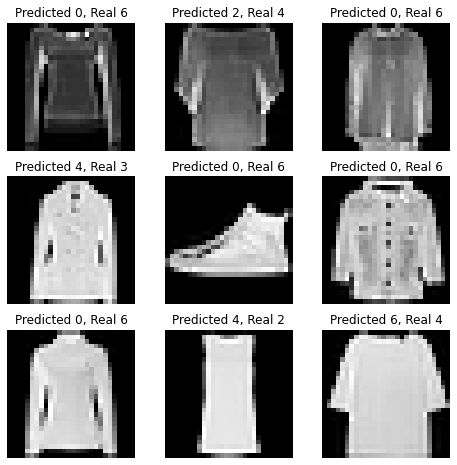

In [24]:
plt.figure(figsize=(8,8))

for j in range(0,9):  
    plt.subplot(3,3,j+1)    
    arr = X_test.iloc[diff[j],:].to_numpy()
    
    arr = arr.reshape(28,28)
    arr = arr.astype(np.uint8)
    img = Image.fromarray(arr, "L")
    
    plt.imshow(img, cmap = 'gray')
    plt.title(f"Predicted {y_pred_np[diff[j+100]]}, Real {y_test_np[diff[j+100]]}")
    plt.axis("off")

plt.show()